# 3.3 GDAL and OGR

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.2-GDAL-and-OGR" data-toc-modified-id="3.2-GDAL-and-OGR-3.1">3.2 GDAL and OGR</a></span><ul class="toc-item"><li><span><a href="#3.3.1-The-MODIS-data" data-toc-modified-id="3.3.1-The-MODIS-data-3.1.1">3.3.1 The MODIS data</a></span></li><li><span><a href="#3.3.2-Reading-and-displaying-data" data-toc-modified-id="3.3.2-Reading-and-displaying-data-3.1.2">3.3.2 Reading and displaying data</a></span></li><li><span><a href="#The-country-borders-dataset" data-toc-modified-id="The-country-borders-dataset-3.1.3">The country borders dataset</a></span></li><li><span><a href="#Putting-it-all-together" data-toc-modified-id="Putting-it-all-together-3.1.4">Putting it all together</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-3.1.5">Exercises</a></span></li></ul></li></ul></div>




In this section, we'll look at combining both raster and vector data to provide a masked dataset ready to use. We will produce a combined dataset of leaf area index (LAI) over the UK derived from the MODIS sensor. The MODIS LAI product is produced every 4 days and it is provided spatially tiled. Each tile covers around 1200 km x 1200 km of the Earth's surface. Below you can see a map showing the MODIS tiling convention.



## 3.3.1 The MODIS data

You should by now be able to download MODIS data, but in this case, the data are provided in the `data` folder as files `MCD15A3H.A2018205.h17v03.006.2018210035249.hdf`  and `MCD15A3H.A2018205.h18v03.006.2018210041159.hdf`. We want to select the LAI layers, so let's have a look at the contents ('sub datasets') of one of the files


In [61]:
import gdal
from geog0111.get_modis_files import get_modis_files


# get some MODIS data
doy,year = 273,2018
tiles = ['h17v03', 'h18v03']
destination_folder = 'data'
filenames = get_modis_files(doy,year,tiles,base_url='https://e4ftl01.cr.usgs.gov/MOTA',\
                                           version=6,\
                                           product='MCD15A3H')
for file_name in [filenames[0]]:
    g = gdal.Open(f)
    for d in g.GetSubDatasets():
        print(d)

('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Fpar_500m', '[2400x2400] Fpar_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m', '[2400x2400] Lai_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:FparLai_QC', '[2400x2400] FparLai_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:FparExtra_QC', '[2400x2400] FparExtra_QC MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:FparStdDev_500m', '[2400x2400] FparStdDev_500m MOD_Grid_MCD15A3H (8-bit unsigned integer)')
('HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:LaiStdDev_500m', '[2400x2400] 

So we see that the data is in HDF4 format, and that it has a number of layers. The layer we're interested in is `HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h18v03.006.2018278143633.hdf":MOD_Grid_MCD15A3H:Lai_500m`.

<div class="alert alert-block alert-info">
Check you're happy that the other dataset follows the same convention!
</div>

We can now have define GDAL fnames. We can then have a look at the metadata of the LAI dataset itself.

In [62]:

gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]

# now refer to a specific (sub) dataset
for file_name in [gdal_fnames[0]]:
    print(f"File: {file_name}")
    print ("\nMetedata Keys:\n")
    g = gdal.Open(file_name)
    
    # get the metadata dictionary keys
    for k in g.GetMetadata().keys():
        print(k)

File: HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m

Metedata Keys:

add_offset
add_offset_err
ALGORITHMPACKAGEACCEPTANCEDATE
ALGORITHMPACKAGEMATURITYCODE
ALGORITHMPACKAGENAME
ALGORITHMPACKAGEVERSION
ASSOCIATEDINSTRUMENTSHORTNAME.1
ASSOCIATEDINSTRUMENTSHORTNAME.2
ASSOCIATEDPLATFORMSHORTNAME.1
ASSOCIATEDPLATFORMSHORTNAME.2
ASSOCIATEDSENSORSHORTNAME.1
ASSOCIATEDSENSORSHORTNAME.2
AUTOMATICQUALITYFLAG.1
AUTOMATICQUALITYFLAGEXPLANATION.1
calibrated_nt
CHARACTERISTICBINANGULARSIZE500M
CHARACTERISTICBINSIZE500M
DATACOLUMNS500M
DATAROWS500M
DAYNIGHTFLAG
DESCRREVISION
EASTBOUNDINGCOORDINATE
ENGINEERING_DATA
EXCLUSIONGRINGFLAG.1
GEOANYABNORMAL
GEOESTMAXRMSERROR
GLOBALGRIDCOLUMNS500M
GLOBALGRIDROWS500M
GRANULEBEGINNINGDATETIME
GRANULEDAYNIGHTFLAG
GRANULEENDINGDATETIME
GRINGPOINTLATITUDE.1
GRINGPOINTLONGITUDE.1
GRINGPOINTSEQUENCENO.1
HDFEOSVersion
HORIZONTALTILENUMBER
identifier_product_doi
identifier_product_doi_authority
INPUTPOINTER
LOCALGRAN

In [63]:
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]

# now refer to a specific (sub) dataset
for file_name in gdal_fnames:
    print(f"\n\nFile: {file_name}\n"+"*"*104)
    g = gdal.Open(file_name)
    
    # get the metadata dictionary keys
    for k in ["LONGNAME","CHARACTERISTICBINSIZE500M",\
              "MOD15A2_FILLVALUE_DOC",\
              "GRINGPOINTLATITUDE.1","GRINGPOINTLONGITUDE.1",\
              'scale_factor']:
        print(k,g.GetMetadata()[k])



File: HDF4_EOS:EOS_GRID:"data/MCD15A3H.A2018273.h17v03.006.2018278143630.hdf":MOD_Grid_MCD15A3H:Lai_500m
********************************************************************************************************
LONGNAME MODIS/Terra+Aqua Leaf Area Index/FPAR 4-Day L4 Global 500m SIN Grid
CHARACTERISTICBINSIZE500M 463.312716527778
MOD15A2_FILLVALUE_DOC MOD15A2 FILL VALUE LEGEND
255 = _Fillvalue, assigned when:
    * the MOD09GA suf. reflectance for channel VIS, NIR was assigned its _Fillvalue, or
    * land cover pixel itself was assigned _Fillvalus 255 or 254.
254 = land cover assigned as perennial salt or inland fresh water.
253 = land cover assigned as barren, sparse vegetation (rock, tundra, desert.)
252 = land cover assigned as perennial snow, ice.
251 = land cover assigned as "permanent" wetlands/inundated marshlands.
250 = land cover assigned as urban/built-up.
249 = land cover assigned as "unclassified" or not able to determine.

GRINGPOINTLATITUDE.1 49.7394264948349, 59.9999999

So we see that the datasets use the MODIS Sinusoidal projection, and that they have different extents. Also we see that the pixel spacing is around 463m, there is a scale factor of 0.1 to be applied etc.

**Exercise E3.3.1**

look at the meta data to discover:

* the number of rows and columns ion the dataset
* the range of valid values

In [64]:
# do exercise here

## 3.3.2 Reading and displaying data

Let's now read some data.

we do this with:

    g.Open(gdal_fname)
    data = g.ReadAsArray()
    
Originally the data are `uint8` (unsigned 8 bit data). 

In [132]:
g = gdal.Open(gdal_fnames[0])
data = g.ReadAsArray()
print(type(data),data.dtype)

<class 'numpy.ndarray'> uint8


We saw that numbers `249` to `254` mean that the land cover class implies no LAI. So we could assign numbers in the range a value of `0`.

We might also want to tag 'invalid' pixel values (`255` here), e.g. as the float value  `np.nan` (not a number). Note that we need to convert from `uint8` data to `float` data first. 

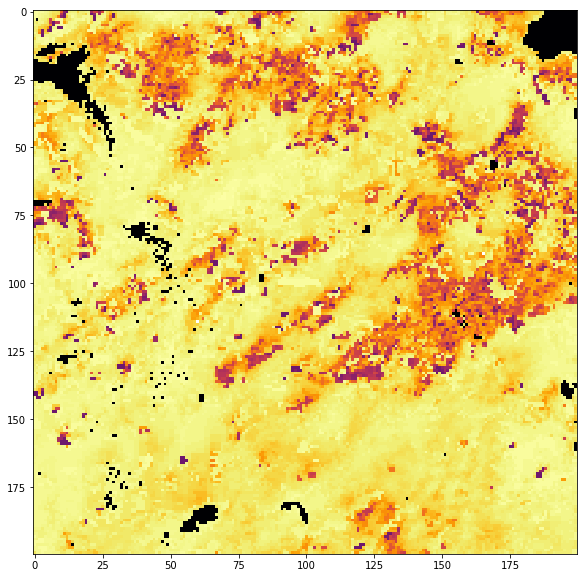

In [142]:
g = gdal.Open(gdal_fnames[0])
data = g.ReadAsArray()

scale = 0.1

data[np.logical_and(data>100,data<=254)] = 101
data = data.astype(float)
data[data==255] = np.nan

data *= scale

snip = data[1300:1500,1300:1500]

plt.figure(figsize=(10,10))
plt.imshow(snip,cmap=plt.cm.inferno_r,interpolation='nearest')

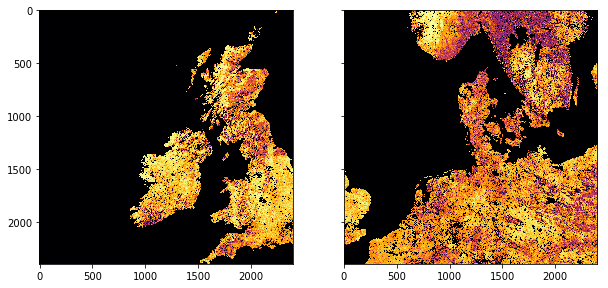

In [130]:
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]

scale_factor = 0.1

g = gdal.Open(gdal_fnames[0])
lai_h17v03 = g.ReadAsArray()*scale_factor # Divide by 10 to get LAI units of m2/m2
g = gdal.Open(gdal_fnames[1])
lai_h18v03 = g.ReadAsArray()*scale_factor # Divide by 10 to get LAI units of m2/m2

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(10,5))

axs[0].imshow(lai_h17v03, interpolation="nearest", vmin=0, vmax=4,
             cmap=plt.cm.inferno_r)
axs[1].imshow(lai_h18v03, interpolation="nearest", vmin=0, vmax=4,
             cmap=plt.cm.inferno_r)

You may want to stitch things together "by hand"...

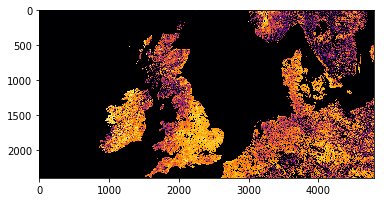

In [100]:
lai_stich = np.c_[ lai_h17v03, lai_h18v03]
plt.imshow(lai_stich, interpolation="nearest", vmin=0, vmax=4,
          cmap=plt.cm.inferno_r)

However, this is problematic if you want to mosaic many tiles, as you need to read in all the data in memory, and some tiles may be missing. GDAL allows you to create a mosaic as [virtual file format](https://www.gdal.org/gdal_vrttut.html), using gdal.BuildVRT (check the documentation). This function takes two inputs: the output filename (`stitch_up.vrt`) and a set of GDAL format filenames. It returns the open output dataset, so that we can check what it looks like with e.g. `gdal.Info`

In [18]:
stitch_vrt = gdal.BuildVRT("stitch_up.vrt", gdal_fnames)
print(gdal.Info(stitch_vrt))


Driver: VRT/Virtual Raster
Files: stitch_up.vrt
Size is 4800, 2400
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]
Origin = (-1111950.519667000044137,6671703.117999999783933)
Pixel Size = (463.312716527916677,-463.312716527916507)
Corner Coordinates:
Upper Left  (-1111950.520, 6671703.118) ( 20d 0' 0.00"W, 60d 0' 0.00"N)
Lower Left  (-1111950.520, 5559752.598) ( 15d33'26.06"W, 50d 0' 0.00"N)
Upper Right ( 1111950.520, 6671703.118) ( 20d 0' 0.00"E, 60d 0' 0.00"N)
Lower Right ( 1111950.520, 5559752.598) ( 15d33'26.06"E, 50d 0' 0.00"N)
Center      (       0.000, 6115727.858) (  0d 0' 0.01"E, 55d 

So we see that we now have 4800 columns by 2400 rows dataset, centered around 55 degrees North, 0 degrees W (somewhere in the North Sea, East of Newcastle). Let's plot the data...

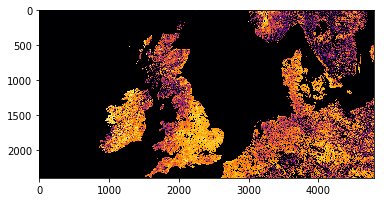

In [101]:
# stitch_vrt is an already opened GDAL dataset, needs to be read in
plt.imshow(sticth_vrt.ReadAsArray()/10.,
           interpolation="nearest", vmin=0, vmax=4, 
          cmap=plt.cm.inferno_r)

## The country borders dataset

A number of vectors with countries and administrative subdivisions are available. The [TM_WORLD_BORDERS shapefile](http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip) is popular and in the public domain. You can see it, and have a look at the data [here](https://koordinates.com/layer/7354-tm-world-borders-03/). We need to download and unzip this file... We'll use requests as before, and we'll unpack the zip file using [`shutil.unpack_archive`](https://docs.python.org/3/library/shutil.html#shutil.unpack_archive)

In [29]:
import requests
import shutil 

tm_borders_url = "http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip"

r = requests.get(tm_borders_url)
with open("data/TM_WORLD_BORDERS-0.3.zip", 'wb') as fp:
    fp.write (r.content)

shutil.unpack_archive("data/TM_WORLD_BORDERS-0.3.zip",
                     extract_dir="data/")

Make sure you have the relevant files available in your `data` folder! We can then inspect the dataset using the command line tool `ogrinfo`. We can call it from the shell by appending the `!` symbol, and select that we want to check only the data for the UK (stored in the `FIPS` field with value `UK`):

<div class="alert alert-block alert-info">
  It is worth noting that using OGR's queries trying to match a string, the string needs to be surrounded by <pre>'</pre>. You can also use more complicated SQL queries if you wanted to.
</div>

In [1]:
!ogrinfo -al data/TM_WORLD_BORDERS-0.3.shp 

INFO: Open of `data/TM_WORLD_BORDERS-0.3.shp'
      using driver `ESRI Shapefile' successful.

Layer name: TM_WORLD_BORDERS-0.3
Metadata:
  DBF_DATE_LAST_UPDATE=2008-07-30
Geometry: Polygon
Feature Count: 246
Extent: (-180.000000, -90.000000) - (180.000000, 83.623596)
Layer SRS WKT:
GEOGCS["GCS_WGS_1984",
    DATUM["WGS_1984",
        SPHEROID["WGS_84",6378137.0,298.257223563]],
    PRIMEM["Greenwich",0.0],
    UNIT["Degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
FIPS: String (2.0)
ISO2: String (2.0)
ISO3: String (3.0)
UN: Integer (3.0)
NAME: String (50.0)
AREA: Integer (7.0)
POP2005: Integer64 (10.0)
REGION: Integer (3.0)
SUBREGION: Integer (3.0)
LON: Real (8.3)
LAT: Real (7.3)
OGRFeature(TM_WORLD_BORDERS-0.3):0
  FIPS (String) = AC
  ISO2 (String) = AG
  ISO3 (String) = ATG
  UN (Integer) = 28
  NAME (String) = Antigua and Barbuda
  AREA (Integer) = 44
  POP2005 (Integer64) = 83039
  REGION (Integer) = 19
  SUBREGION (Integer) = 29
  LON (Real) = -61.783
  LAT (Real) = 17

  MULTIPOLYGON (((-68.608612 -54.891396,-68.62056 -54.891396,-68.643112 -54.888611,-68.637222 -54.885002,-68.636124 -54.804771,-68.62529 -54.811111,-68.62056 -54.815002,-68.557236 -54.874451,-68.557236 -54.880005,-68.572784 -54.884727,-68.599167 -54.890007,-68.608612 -54.891396)),((-63.813614 -54.731392,-63.865837 -54.782501,-63.871391 -54.786118,-63.954727 -54.811951,-63.975838 -54.79084,-64.011398 -54.778618,-64.040283 -54.790001,-64.135559 -54.818893,-64.253891 -54.842224,-64.261124 -54.839729,-64.265015 -54.835007,-64.268066 -54.829445,-64.26973 -54.823334,-64.265289 -54.806114,-64.326401 -54.788612,-64.349167 -54.803062,-64.418625 -54.838615,-64.426956 -54.840836,-64.452515 -54.846947,-64.463348 -54.848061,-64.485001 -54.847229,-64.572784 -54.866669,-64.581116 -54.868896,-64.63945 -54.90139,-64.678345 -54.907227,-64.66806 -54.871948,-64.670563 -54.866394,-64.699448 -54.848618,-64.70668 -54.846115,-64.727234 -54.844452,-64.747513 -54.844452,-64.753616 -54.841118,-64.75528 -54.83500

  MULTIPOLYGON (((158.882172 -54.711388,158.879669 -54.753891,158.836914 -54.752502,158.833313 -54.749725,158.828857 -54.738892,158.828857 -54.73333,158.829956 -54.710556,158.833862 -54.668892,158.848297 -54.623611,158.891083 -54.519997,158.906647 -54.49472,158.913605 -54.491943,158.957458 -54.474716,158.963287 -54.47805,158.952454 -54.546112,158.951355 -54.552223,158.945526 -54.576393,158.941925 -54.588051,158.938293 -54.599724,158.936096 -54.605003,158.931091 -54.616112,158.906097 -54.66333,158.888306 -54.6875,158.884705 -54.699165,158.882172 -54.711388)),((147.362732 -43.398056,147.322205 -43.500557,147.319122 -43.50528,147.310516 -43.511948,147.302765 -43.513336,147.239136 -43.491669,147.175537 -43.501671,147.123016 -43.421944,147.190247 -43.354446,147.287201 -43.266113,147.291931 -43.261948,147.300262 -43.262779,147.307739 -43.270279,147.362457 -43.374168,147.36496 -43.385834,147.362732 -43.398056)),((147.429688 -43.253616,147.361633 -43.263062,147.291931 -43.164444,147.291931 -43

  MULTIPOLYGON (((-48.55056 -27.821392,-48.556671 -27.822781,-48.563057 -27.821392,-48.565285 -27.816669,-48.566673 -27.811111,-48.566673 -27.798889,-48.565834 -27.792778,-48.55056 -27.696114,-48.53167 -27.646946,-48.502785 -27.561668,-48.501114 -27.556114,-48.501114 -27.549168,-48.503334 -27.544445,-48.521667 -27.518333,-48.527779 -27.491669,-48.523613 -27.466393,-48.518333 -27.435558,-48.517227 -27.430836,-48.43084 -27.390003,-48.424728 -27.388889,-48.418335 -27.388889,-48.414169 -27.39167,-48.410835 -27.395557,-48.371948 -27.443611,-48.371117 -27.449722,-48.406395 -27.592781,-48.412506 -27.601112,-48.448334 -27.630836,-48.458893 -27.641945,-48.496674 -27.711391,-48.499725 -27.722504,-48.500557 -27.728615,-48.499725 -27.734726,-48.498337 -27.74028,-48.492226 -27.748611,-48.485001 -27.756111,-48.479729 -27.765003,-48.479729 -27.771667,-48.482224 -27.776669,-48.486115 -27.780003,-48.540558 -27.816669,-48.55056 -27.821392)),((-48.581116 -26.39167,-48.585838 -26.425556,-48.626114 -26.393

  MULTIPOLYGON (((-65.613617 43.420273,-65.61972 43.418053,-65.625 43.421379,-65.636124 43.449715,-65.633057 43.474709,-65.611389 43.513054,-65.605835 43.516106,-65.598343 43.515831,-65.566101 43.508331,-65.561935 43.50444,-65.559998 43.499718,-65.573334 43.476379,-65.593613 43.444153,-65.613617 43.420273)),((-59.816948 43.928329,-59.841667 43.918602,-59.866394 43.909988,-59.879723 43.906654,-59.895836 43.90416,-59.919449 43.9011,-59.953331 43.898605,-60.013618 43.90332,-60.02861 43.905548,-60.078339 43.917496,-60.103889 43.926659,-60.121666 43.93499,-60.129997 43.941933,-60.124168 43.945267,-60.095001 43.93943,-60.017776 43.925827,-59.975555 43.921936,-59.966942 43.921936,-59.915001 43.925552,-59.861946 43.934433,-59.841385 43.938881,-59.809723 43.950829,-59.793335 43.959435,-59.777222 43.968048,-59.75528 43.979431,-59.724716 43.991104,-59.727776 43.986382,-59.736389 43.979156,-59.753616 43.964996,-59.762505 43.957771,-59.782501 43.944435,-59.79306 43.938324,-59.816948 43.928329)),((-

89 68.1147,-106.85611 68.116928,-106.84111 68.116379,-106.801941 68.197479,-106.809433 68.207214,-106.806107 68.213043,-106.800278 68.217484,-106.791107 68.221375,-106.627487 68.246643,-106.614441 68.248032,-106.599442 68.247482,-106.588608 68.244141,-106.468613 68.190536,-106.457779 68.176376,-106.454178 68.160812,-106.450562 68.155823,-106.444717 68.151657,-106.431953 68.153046,-106.421387 68.156097,-106.350563 68.179153,-106.344727 68.183319,-106.350563 68.187759,-106.358887 68.19165,-106.392776 68.20166,-106.420837 68.207214,-106.468887 68.214432,-106.481949 68.217484,-106.48999 68.221375,-106.495827 68.22554,-106.497223 68.23082,-106.468338 68.329712,-106.465012 68.335815,-106.456673 68.34082,-106.447487 68.344711,-106.426392 68.350815,-106.256119 68.387772,-106.244164 68.389984,-106.218338 68.392487,-106.203056 68.392212,-106.185272 68.389984,-106.174713 68.386658,-106.166656 68.382751,-106.154716 68.373871,-105.796387 68.422211,-105.790558 68.418045,-105.782227 68.413879,-105.76

.051941 69.008606,-75.036118 68.992203,-75.037781 68.985809,-75.071396 68.921097,-75.075562 68.915817,-75.109161 68.894989,-75.116394 68.890823,-75.124161 68.888046,-75.139725 68.88472,-75.169998 68.886383,-75.19249 68.891663,-75.20195 68.89444,-75.315826 68.9422,-75.373886 68.968872,-75.383331 68.974426,-75.400284 68.985535,-75.422501 69.001938,-75.445831 69.016937,-75.454453 69.021103,-75.4664 69.021378,-75.478882 69.019714,-75.494156 69.016388,-75.528336 69.005829,-75.565552 68.993591,-75.573624 68.988586,-75.578613 68.984146,-75.580841 68.97554,-75.574173 68.968323,-75.537781 68.951096,-75.506958 68.939697,-75.499725 68.934708,-75.494995 68.930267,-75.534164 68.90387,-75.54277 68.89888,-75.565277 68.891373,-75.603882 68.8797,-75.647781 68.869141,-75.809158 68.836929,-75.976105 68.791092,-75.979446 68.787201,-75.985001 68.783875,-75.995544 68.779434,-76.008621 68.775543,-76.049438 68.764435,-76.227219 68.7211,-76.327225 68.697479,-76.376099 68.687485,-76.420547 68.679153,-76.436386 

,-119.535553 75.962494,-119.546387 75.968323,-119.561111 75.978867,-119.571953 75.984985,-119.585831 75.9897,-119.612503 75.992477,-119.636948 75.992203,-119.648903 75.986649,-119.699997 75.948593,-119.703339 75.942749,-119.6875 75.938309,-119.612503 75.910263,-119.810822 75.869431,-119.870003 75.857483,-119.935547 75.848328,-119.980003 75.843323,-120.025833 75.839981,-120.049156 75.838882,-120.076401 75.867203,-120.085007 75.872757,-120.114166 75.888321,-120.128052 75.893051,-120.14917 75.896378,-120.166397 75.892487,-120.180283 75.879974,-120.183319 75.873871,-120.19722 75.861374,-120.215012 75.848602,-120.22583 75.842209,-120.26973 75.82193,-120.288887 75.816086,-120.309158 75.811096,-120.33223 75.80748,-120.35556 75.806366,-120.378052 75.806641,-120.403877 75.808319,-120.430283 75.811096,-120.454453 75.815811,-120.466949 75.821106,-120.47583 75.82666,-120.485283 75.837769,-120.488602 75.844147,-120.489723 75.849991,-120.488327 75.855545,-120.463058 75.916382,-120.460007 75.922485,-

  ISO2 (String) = CN
  ISO3 (String) = CHN
  UN (Integer) = 156
  NAME (String) = China
  AREA (Integer) = 932743
  POP2005 (Integer64) = 1312978855
  REGION (Integer) = 142
  SUBREGION (Integer) = 30
  LON (Real) = 106.514
  LAT (Real) = 33.420
  MULTIPOLYGON (((110.524147 19.134441,110.5186 19.131939,110.514999 19.132774,110.512497 19.134441,110.510536 19.136383,110.510269 19.139164,110.512772 19.140831,110.517906 19.140965,110.521927 19.139717,110.524147 19.137775,110.524147 19.134441)),((110.720543 20.063332,110.773323 20.012775,110.77832 20.009441,110.781372 20.008053,110.847214 19.989716,110.854431 19.988049,110.866379 19.988605,110.875526 19.99194,110.896652 20.0,110.916656 20.0075,110.924149 20.007221,110.930817 20.001389,110.93248 19.998882,110.940536 19.982773,110.944427 19.974438,110.968048 19.890274,111.030823 19.643608,111.031097 19.639996,111.02916 19.637775,111.022491 19.636108,111.014709 19.637218,110.967758 19.631664,110.93692 19.599998,110.874687 19.541943,110.868317 

  MULTIPOLYGON (((-67.212784 -55.893616,-67.246948 -55.895004,-67.349731 -55.863617,-67.40889 -55.836395,-67.413895 -55.83223,-67.408066 -55.821945,-67.401947 -55.818611,-67.394455 -55.815834,-67.376114 -55.812225,-67.320282 -55.814728,-67.246948 -55.828056,-67.212234 -55.855835,-67.204453 -55.886116,-67.205566 -55.890839,-67.212784 -55.893616)),((-67.493057 -55.82917,-67.494171 -55.834167,-67.521667 -55.874451,-67.525284 -55.879173,-67.530289 -55.883339,-67.538895 -55.885559,-67.58168 -55.875282,-67.591675 -55.873894,-67.596115 -55.878059,-67.611954 -55.902229,-67.641678 -55.85556,-67.646393 -55.851669,-67.655014 -55.849449,-67.713623 -55.849724,-67.783066 -55.861389,-67.83168 -55.869171,-67.841675 -55.867783,-67.847778 -55.864174,-67.852509 -55.860283,-67.856125 -55.855278,-67.857513 -55.849167,-67.8564 -55.843056,-67.853897 -55.837502,-67.844177 -55.822502,-67.836945 -55.819725,-67.808899 -55.816391,-67.797791 -55.815559,-67.771118 -55.821114,-67.751678 -55.823891,-67.711395 -55.828

  POLYGON ((14.500875 13.001314,14.486944 13.019722,14.472776 13.040277,14.459444 13.061388,14.454721 13.070555,14.443054 13.084721,14.428888 13.085278,14.159721 13.083055,14.07472 13.081665,13.901077 13.328215,13.760015 13.527803,13.634722 13.703888,13.62512 13.718338,13.600555 13.828609,13.562229 13.993265,13.462221 14.428055,13.461666 14.433054,13.463333 14.445276,13.466665 14.456388,13.468887 14.461111,13.482777 14.474998,13.49472 14.484444,13.517221 14.496944,13.540277 14.50861,13.554722 14.514999,13.615181 14.516262,13.629721 14.521666,13.647778 14.531666,13.665277 14.541943,13.672777 14.548611,13.67861 14.556944,13.680832 14.561666,13.684166 14.572498,13.684721 14.586388,13.684444 14.599443,13.681389 14.617498,13.759165 14.705555,13.794167 14.732777,13.77861 14.802221,13.767221 14.848055,13.786388 14.888887,13.859165 15.037777,13.997221 15.205832,14.072222 15.313889,14.195555 15.489166,14.271666 15.596943,14.368889 15.733889,14.572222 15.947777,14.904444 16.29472,15.122221 16.52

  MULTIPOLYGON (((-9.656389 53.222221,-9.663334 53.221382,-9.688612 53.222771,-9.695557 53.223328,-9.70389 53.226944,-9.709723 53.232498,-9.725557 53.263885,-9.724724 53.268051,-9.670557 53.281662,-9.664446 53.281944,-9.660833 53.279999,-9.641945 53.251938,-9.648613 53.226944,-9.656389 53.222221)),((-9.964169 54.018608,-9.940556 53.997772,-9.936111 53.991386,-9.923889 53.950554,-9.923889 53.945831,-9.926111 53.923882,-9.940834 53.886665,-9.943335 53.883331,-9.950556 53.878326,-9.955002 53.876663,-9.96139 53.875832,-9.978613 53.87944,-10.055557 53.909439,-10.06139 53.919716,-10.062778 53.923332,-10.062778 53.927773,-10.152224 53.959717,-10.174168 53.960831,-10.264168 53.968605,-10.268612 53.974998,-10.265556 53.977776,-10.196667 54.008331,-10.189445 54.008888,-10.15889 54.009163,-10.125 54.001663,-10.119522 54.0,-10.069168 54.02166,-10.063057 54.022499,-9.974167 54.021942,-9.968056 54.020828,-9.964169 54.018608)),((-8.436945 54.944443,-8.443335 54.943886,-8.448891 54.945274,-8.452501 54

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We inmediately see that the coordinates for the UK are in several polygons, and in WGS84 (Latitude and Longitude in decimal degrees). This is incompatible with the MODIS data.

We can use GDAL to quickly apply the vector feature for the UK as a mask. There are several ways of doing this, but the simplest is to use [gdal.Warp](https://www.gdal.org/gdalwarp.html) (the link is to the command line tool). In this case, we just want to create:

* an in-memory (i.e. not saved to a file) dataset. We can use the format `MEM`, so no file is written out
* where the FIPS field is equal to "UK", we want the LAI to show, elsewhere, we set it to (e.g.) "no data" (e.g. -999)


The mosaicked version of the MODIS LAI product is in file `stitch_up.vrt`. Since we're not saving the output to a file (`MEM` output option), we can leave the output as an empty string `""`. The shapefile comes with the `cutline` options:

* `cutlineDSName` that's the name of the vector file we want to use as a cutline
* `cutlineWhere` that's the selection statement for the attribute table in the dataset. 

To set the no data value to 200, we can use the option `dstNodata=200`. This is because very large values in the LAI product are already indicated to be invalid.

We can then just very quickly perform this and check...

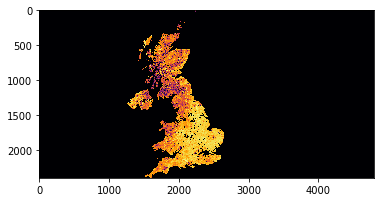

In [78]:
g = gdal.Warp("", "stitch_up.vrt",
         format = 'MEM',dstNodata=200,
          cutlineDSName = 'data/TM_WORLD_BORDERS-0.3.shp', cutlineWhere = "FIPS='UK'")
masked_lai = g.ReadAsArray()/10.
plt.imshow(masked_lai, interpolation="nearest", vmin=0, vmax=6, 
          cmap=plt.cm.inferno_r)

So that works as expected, but since we haven't actually told GDAL anything about the output (other than apply the mask), we still have a 4800 pixel wide dataset. You may want to crop it by looking for where the original dataset is  *not* -999, or in fact, for pixels that are bigger than 0. You'll be pleased to know that this is a great slicing application!

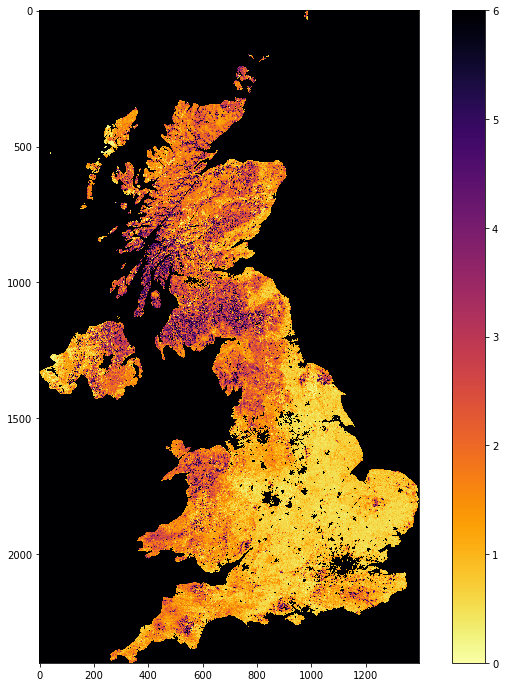

In [81]:
lai = g.ReadAsArray()
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()


## Putting it all together

The previous steps can be put together in a function. It is even possible to simplify things a bit more by not even storing the name of the stitiched up VRT file:

## Exercises

* Put everything together as a function
* Mask pixels outside the Netherlands
* Mask pixels outside Ireland


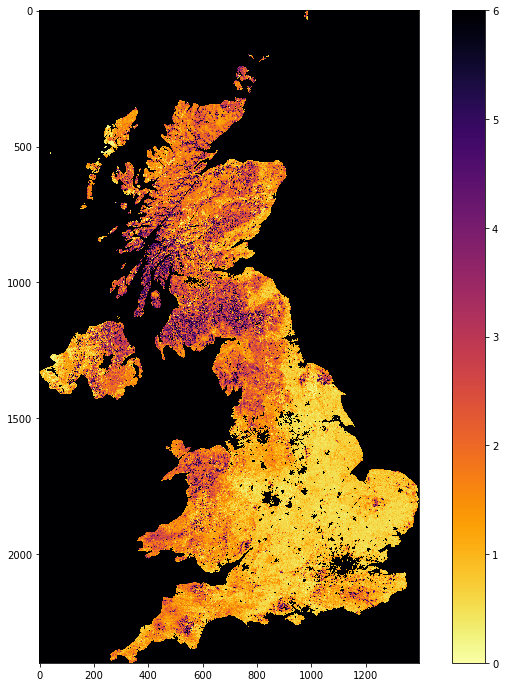

In [90]:
def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)

    return g

g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='UK'")
lai = g.ReadAsArray()
mask = np.nonzero(lai < 200)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()


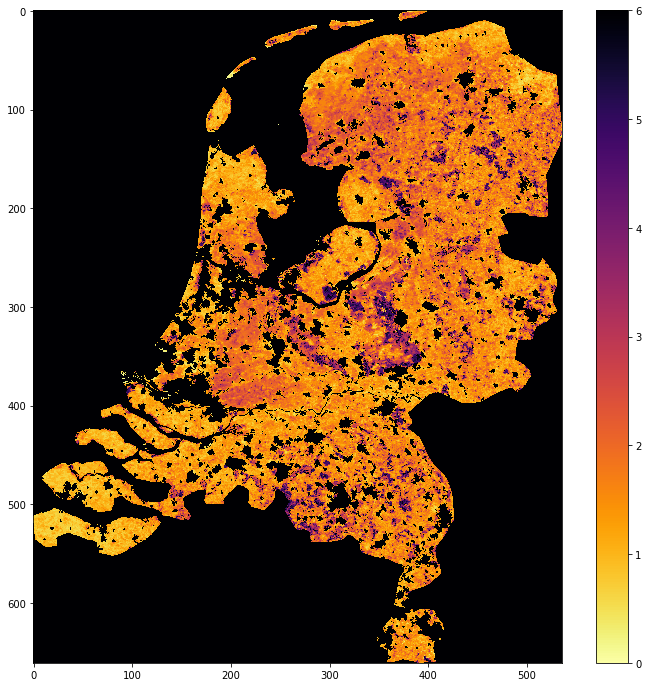

In [98]:
g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='NL'")
lai = g.ReadAsArray()
mask = np.nonzero(lai < 200)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

plt.figure(figsize=(12,12))
plt.imshow( lai[min_y:max_y,
               min_x:max_x]/10., vmin=0, vmax=6,
           cmap=plt.cm.inferno_r)
plt.colorbar()